In [1]:
import pandas as pd
from sqlalchemy import *
import sys
import os
import matplotlib.pyplot as pyplot
from sklearn.utils import shuffle
from sklearn import preprocessing, cross_validation, ensemble, linear_model, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import statsmodels.api as sm
%matplotlib inline


In [2]:
db = create_engine('sqlite://///Users/Gabi/Dropbox/Shareablee/biomechanics/data/biomechanics-with-negatives201512v2.db')
db.echo = True
metadata = MetaData(db)

In [3]:
'''
Fill in NA values
1) using average for that group for that column
2) using average of that column (this only happens if there s still NAs)
3) option to delete columns with "paid" 
'''
def clean(dat, threshold = 0.80, delete_paid = False):
    dat = dat.copy()

    dat.drop([c for c in dat if dat[c].isnull().sum()/nrows >.80], axis = 1, inplace=True)
    if delete_paid:
        dat.drop([x for x in dat.columns if 'paid' in x], axis = 1, inplace = True)
    dat.facebook_page_id = dat.facebook_page_id.astype(np.str)
    dat.name = dat.name.map(lambda x: x.lower())


    cols_fill = [c for c in dat.columns if (dat[c].isnull().sum()/nrows < threshold) and (dat[c].isnull().sum()/nrows >0.00)]
    for i in cols_fill:
        dat[i].fillna(dat.groupby('facebook_post_id')[i].transform("mean"), inplace = True)
        dat[i].fillna(dat[i].mean(), inplace = True)
    return dat

'''
helper function to get verticals
output: 2 dictionaries: 
    1) page_id, vertical mapping
    2) page_name, vertical mapping 
'''
def get_verticals():
    verticals = pd.read_table('~/Downloads/fb_account_info.txt')
    verticals = verticals.drop_duplicates()
    verticals.page_id = verticals.page_id.astype(np.str)
    verticals.page_name = verticals.page_name.map(lambda x: x.lower())
    sub = verticals[['page_id','page_name','vertical']].drop_duplicates()
    sub.page_id = sub.page_id.astype(np.int)
    sub.set_index('page_id', inplace=True)

    dict_vert = dict(zip(sub.index, sub.vertical))
    dict_names = dict(zip(sub.page_name.map(lambda x: x.split()[0].strip()), sub.vertical))
    dict_names["huff/post50"] = 'Publishing'
    dict_names["huffpostde politik"] = 'Publishing'
    dict_names["johnson’s baby"] = 'Consumer Goods'
    return [dict_vert, dict_names]

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=pyplot.cm.Blues):
    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(target_names))
    pyplot.xticks(tick_marks, target_names, rotation=45)
    pyplot.yticks(tick_marks, target_names)
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')


'''
helper function to nicely print confusion matrix
'''
def get_confusion_matrix(actual_y, predicted_y):
    confusion_index =  ['0-Actual','1-Actual']
    confusion_cols = ['0-Predicted','1-Predicted']
    confusion_df = pd.DataFrame(confusion_matrix(actual_y, predicted_y), index = confusion_index, columns = confusion_cols)
    return confusion_df

In [4]:
qry_joins = 'select p.id, p.facebook_page_id, p.name, po.page_id, po.facebook_post_id, \
ps.impressions_paid_unique, ps.impressions_fan_paid_unique, ps.impressions_fan_unique, ps.impressions_organic_unique, \
ps.impressions_by_story_type_unique_other, \
ps.consumptions_by_type_unique_link_clicks, ps.consumptions_by_type_unique_photo_view, ps.consumptions_by_type_unique_video_play, \
ps.consumptions_by_type_unique_other_clicks, ps.consumptions_unique, \
ps.negative_feedback_by_type_unique_hide_clicks, ps.negative_feedback_by_type_unique_hide_all_clicks, ps.negative_feedback_unique, \
ps.video_views_paid_unique, ps.video_views_organic_unique, ps.video_complete_views_organic_unique, ps.video_complete_views_paid_unique, \
CASE  WHEN ps.impressions_paid_unique > 0 THEN 1 ELSE 0 END as is_promoted \
from pages as p inner join posts as po on p.id = po.page_id inner join post_insights as ps on ps.post_id = po.id'

# data from posts_insights, posts, and pages 
df_joined = pd.read_sql_query(qry_joins, con = db)


2016-05-07 23:26:22,875 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2016-05-07 23:26:22,876 INFO sqlalchemy.engine.base.Engine ()
2016-05-07 23:26:22,878 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2016-05-07 23:26:22,878 INFO sqlalchemy.engine.base.Engine ()
2016-05-07 23:26:22,880 INFO sqlalchemy.engine.base.Engine select p.id, p.facebook_page_id, p.name, po.page_id, po.facebook_post_id, ps.impressions_paid_unique, ps.impressions_fan_paid_unique, ps.impressions_fan_unique, ps.impressions_organic_unique, ps.impressions_by_story_type_unique_other, ps.consumptions_by_type_unique_link_clicks, ps.consumptions_by_type_unique_photo_view, ps.consumptions_by_type_unique_video_play, ps.consumptions_by_type_unique_other_clicks, ps.consumptions_unique, ps.negative_feedback_by_type_unique_hide_clicks, ps.negative_feedback_by_type_unique_hide_all_clicks, ps.negative_feedback_unique, ps.video_views

In [5]:
# check nulls in each column
nrows = np.float(df_joined.shape[0])
df_joined.isnull().sum()/nrows

id                                                  0.000000
facebook_page_id                                    0.000000
name                                                0.000000
page_id                                             0.000000
facebook_post_id                                    0.000000
impressions_paid_unique                             0.012109
impressions_fan_paid_unique                         0.012109
impressions_fan_unique                              0.012109
impressions_organic_unique                          0.012109
impressions_by_story_type_unique_other              0.035204
consumptions_by_type_unique_link_clicks             0.106341
consumptions_by_type_unique_photo_view              0.420695
consumptions_by_type_unique_video_play              0.872761
consumptions_by_type_unique_other_clicks            0.024472
consumptions_unique                                 0.012109
negative_feedback_by_type_unique_hide_clicks        0.138884
negative_feedback_by_typ

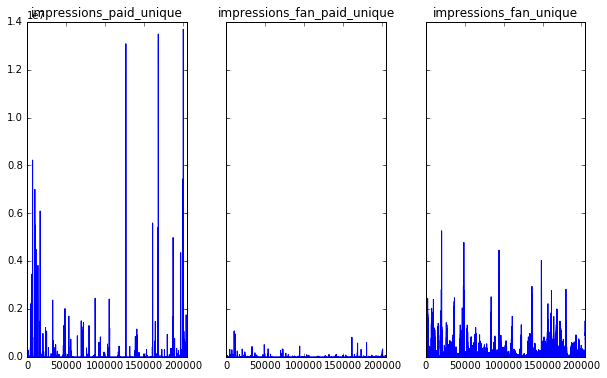

In [6]:
'''
Data Exploration: what's in the columns? Which columns have the most useful information?
'''

sub_dat = df_joined.ix[:, 5:8]
fig, axes = pyplot.subplots(nrows=1, ncols=3, figsize=(10,6), sharey=True)
for i, var in enumerate(sub_dat.columns):
    sub_dat[[i]].plot(ax = axes[i], title = var, legend ='')
fig.subplots_adjust(hspace=0.25, wspace=0.25)
pyplot.show()


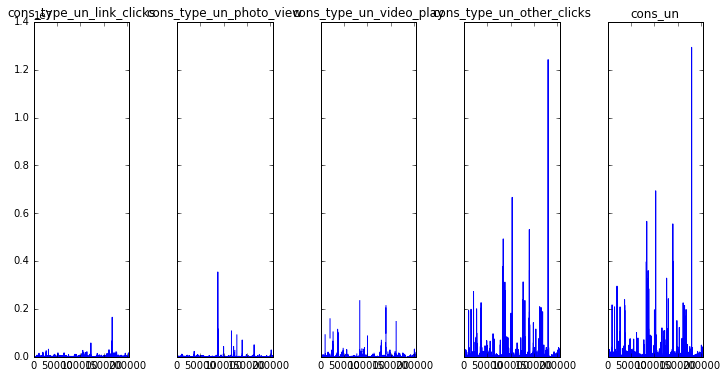

In [7]:
sub_dat = df_joined.ix[:, 10:15]
fig, axes = pyplot.subplots(nrows=1, ncols=5, figsize=(12,6), sharey=True)
for i, var in enumerate(sub_dat.columns):
    l = var.replace('consumptions', 'cons').replace('impressions','imp').replace('by_','').replace('unique','un') 
    sub_dat[[i]].plot(ax = axes[i], title = l, legend ='')
fig.subplots_adjust(hspace=0.5, wspace=0.5)
pyplot.show()

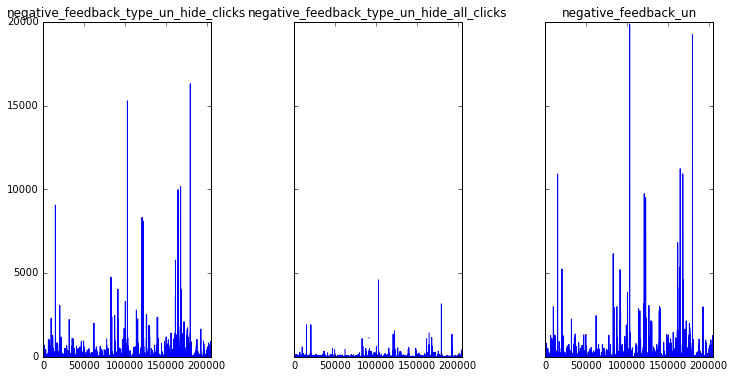

In [8]:
sub_dat = df_joined.ix[:, 15:18]
fig, axes = pyplot.subplots(nrows=1, ncols=3, figsize=(12,6), sharey=True)
for i, var in enumerate(sub_dat.columns):
    l = var.replace('consumptions', 'cons').replace('impressions','imp').replace('by_','').replace('unique','un') 
    sub_dat[[i]].plot(ax = axes[i], title = l, legend ='')
fig.subplots_adjust(hspace=0.5, wspace=0.5)
pyplot.show()

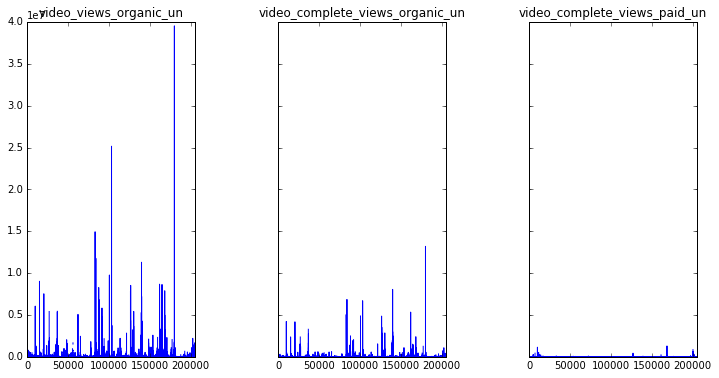

In [9]:
sub_dat = df_joined.ix[:, 19:22]
fig, axes = pyplot.subplots(nrows=1, ncols=3, figsize=(12,6), sharey=True)
for i, var in enumerate(sub_dat.columns):
    l = var.replace('consumptions', 'cons').replace('impressions','imp').replace('by_','').replace('unique','un') 
    sub_dat[[i]].plot(ax = axes[i], title = l, legend ='')
fig.subplots_adjust(hspace=0.5, wspace=0.5)
pyplot.show()

### Thoughts on the data
After looking at columns, will make a first attempt at using Logistic regression with the entire dataset
then will use:
* impressions_fan_unique
* consumptions_unique
* negative_feedback_unique
* video_views_organic_unique

### Next Steps:
Clean data:
* fill in missing values with average based on facebook_page_id for each column
* if NA's still exist fill in using average for that column
* scale data - more on this later
* possibly add 'verticals'


In [10]:
'''
DATA PRE-PROCESSING
'''

data = clean(df_joined, threshold = 0.8, delete_paid=True)
# make sure no NANs
data.isnull().sum()/nrows

# get verticals 
dict_vert, dict_names = get_verticals()
# add verticals to data
data['vertical'] = data.facebook_page_id.map(lambda x: dict_vert.get(x,'None'))
data['temp'] = data.name.map(lambda x: x.split()[0].strip())
data.loc[data.vertical =='None','vertical'] = data[data.vertical =='None'].temp.map(lambda x: dict_names.get(x,'None'))

# remove cols with names and id
cols_remove =['id','page_id', 'facebook_post_id','name', 'temp']
data = data.drop(cols_remove, axis = 1)

data.head()

,facebook_page_id,impressions_fan_unique,impressions_organic_unique,impressions_by_story_type_unique_other,consumptions_by_type_unique_link_clicks,consumptions_by_type_unique_photo_view,consumptions_by_type_unique_other_clicks,consumptions_unique,negative_feedback_by_type_unique_hide_clicks,negative_feedback_by_type_unique_hide_all_clicks,negative_feedback_unique,video_views_organic_unique,video_complete_views_organic_unique,is_promoted,vertical
0,437314992973512,91.0,94.0,5.0,2513.593163,2.0,3.0,5.0,34.278056,1.0,1.0,13616.693286,4822.538318,0,Services
1,437314992973512,105.0,109.0,8.0,2513.593163,2.0,3.0,5.0,34.278056,1.0,1.0,13616.693286,4822.538318,0,Services
2,437314992973512,115.0,132.0,9.0,2513.593163,2.0,3.0,5.0,34.278056,1.0,1.0,13616.693286,4822.538318,0,Services
3,437314992973512,115.0,135.0,9.0,2513.593163,2.0,3.0,5.0,34.278056,1.0,1.0,13616.693286,4822.538318,0,Services
4,437314992973512,116.0,138.0,9.0,2513.593163,2.0,3.0,5.0,34.278056,1.0,1.0,13616.693286,4822.538318,0,Services


### Data Standardization
The result of standardization is that the features will be rescaled to have the properties of a standard normal distribution with
μ=0 and σ =1 (mean = 0 and standard deviation =1)


In [11]:
# normalize data
data.ix[:,1:-2] = preprocessing.scale(data.ix[:,1:-2])
data = data.drop(['is_promoted','vertical'], axis = 1).join(data.is_promoted)
data['intercept'] = 1.0

In [12]:
'''
Logistic Regression #1 - on entire dataset, all rows & columns
SPOILER ALERT....PREDICTS ALL 0'S
'''
cols_train = data.drop('is_promoted', axis = 1).columns
X = data[cols_train]
y = data.is_promoted
target_names = ['class 0', 'class 1']

logreg = LogisticRegression(C=1e9)
logreg.fit(X,y)
data['promo_pred_1'] = logreg.predict(X)

In [13]:
# look at predictions & results
print "Predictions:\n", data.promo_pred_1.value_counts()
print
# confusion matrix
print "Confusion Matrix\n", get_confusion_matrix(y, data.promo_pred_1)
print
print "Classification report\n", classification_report(y, data.promo_pred_1)
print
# look at coefficients to see indication of relationship btw inputs and output
zip(X.columns, logreg.coef_.flatten())


Predictions:
0    204804
Name: promo_pred_1, dtype: int64

Confusion Matrix
          0-Predicted  1-Predicted
0-Actual       201448            0
1-Actual         3356            0

Classification report
             precision    recall  f1-score   support

          0       0.98      1.00      0.99    201448
          1       0.00      0.00      0.00      3356

avg / total       0.97      0.98      0.98    204804




/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[(u'facebook_page_id', -1.303572786210156e-14),
 (u'impressions_fan_unique', -2.515819934765487e-28),
 (u'impressions_organic_unique', -1.7768980230205087e-28),
 (u'impressions_by_story_type_unique_other', 5.8953178336955866e-31),
 (u'consumptions_by_type_unique_link_clicks', -6.8519298727175995e-29),
 (u'consumptions_by_type_unique_photo_view', -1.5088889515630088e-29),
 (u'consumptions_by_type_unique_other_clicks', -8.2123018571574964e-30),
 (u'consumptions_unique', -1.9407987468557431e-29),
 (u'negative_feedback_by_type_unique_hide_clicks', -5.2105213439080107e-29),
 (u'negative_feedback_by_type_unique_hide_all_clicks',
  -1.2961330411644925e-29),
 (u'negative_feedback_unique', -6.9489748803136481e-29),
 (u'video_views_organic_unique', -5.3837814890051203e-31),
 (u'video_complete_views_organic_unique', 4.6702179584345991e-30),
 ('intercept', -1.5636715929856162e-27)]

Confusion matrix, without normalization
[[201448      0]
 [  3356      0]]


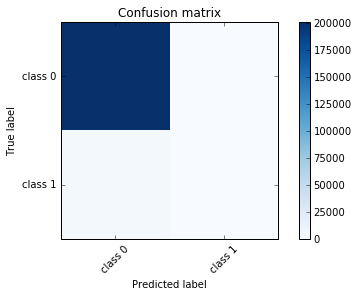

In [14]:
# Compute confusion matrix
cm = confusion_matrix(y, data.promo_pred_1)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
pyplot.figure()
plot_confusion_matrix(cm)

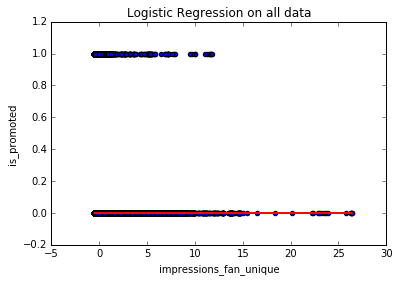

In [15]:
# plot the class predictions
pyplot.scatter(data.impressions_fan_unique, data.is_promoted)
pyplot.plot(data.impressions_fan_unique, data.promo_pred_1, color='red')
pyplot.xlabel('impressions_fan_unique')
pyplot.ylabel('is_promoted')
pyplot.title("Logistic Regression on all data")
pyplot.show()



### Logistic Regression 1 Results:
* Predicted all posts to be unpromoted (class 0)
* Accuracy score is high because it doesnt take into account the imbalance of classes in the data
* All coefficients are very small indicating small movement in output caused by an increase/decrease in input

### Next steps
* Take into account class imbalance in data
* Create training and test set


In [16]:
'''
Logistic Regression #2 - on .80 dataset & using balanced classes
PREDICTS ALL 1'S
'''
# training and testing
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=1)
Cs = np.logspace(-4, 4, 3)
logreg2 = LogisticRegression(C=Cs[0], class_weight='balanced', multi_class = 'ovr')
logreg2.fit(X_train,y_train)
promo_pred_2 = logreg2.predict(X_test)

In [17]:
# Look at how well this version performed
print "Average score %.4f'" % logreg2.score(X_test, y_test)
print 

# look at predictions & results
print "Predictions:\n", pd.value_counts(promo_pred_2)
print
# confusion matrix
print "Confusion Matrix\n", get_confusion_matrix(y_test, promo_pred_2)
print
print "Classification report\n", classification_report(y_test, promo_pred_2)
print

# look at coefficients to see indication of relationship btw inputs and output
zip(X_test.columns, logreg2.coef_.flatten())

Average score 0.0163'

Predictions:
1    40961
dtype: int64

Confusion Matrix
          0-Predicted  1-Predicted
0-Actual            0        40292
1-Actual            0          669

Classification report
             precision    recall  f1-score   support

          0       0.00      0.00      0.00     40292
          1       0.02      1.00      0.03       669

avg / total       0.00      0.02      0.00     40961




[(u'facebook_page_id', 4.3119577633479891e-16),
 (u'impressions_fan_unique', -8.1611763300143994e-31),
 (u'impressions_organic_unique', -1.2440457105805169e-31),
 (u'impressions_by_story_type_unique_other', 4.0583516765594136e-30),
 (u'consumptions_by_type_unique_link_clicks', 2.0114045238676701e-30),
 (u'consumptions_by_type_unique_photo_view', -1.1519284392873536e-31),
 (u'consumptions_by_type_unique_other_clicks', 3.3179039167255462e-30),
 (u'consumptions_unique', 4.1527504590139668e-30),
 (u'negative_feedback_by_type_unique_hide_clicks', 2.5646006230495904e-30),
 (u'negative_feedback_by_type_unique_hide_all_clicks', 1.9209143320706863e-30),
 (u'negative_feedback_unique', 2.6081590434107546e-30),
 (u'video_views_organic_unique', 4.1144036462883249e-30),
 (u'video_complete_views_organic_unique', 4.0408093161021911e-30),
 ('intercept', -1.0854332743128038e-30)]

Confusion matrix
[[    0 40292]
 [    0   669]]


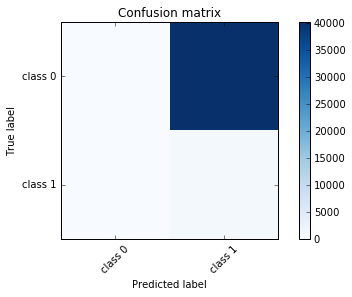

In [18]:
# Compute confusion matrix
cm_2 = confusion_matrix(y_test, promo_pred_2)
print('Confusion matrix')
print(cm_2)
pyplot.figure()
plot_confusion_matrix(cm_2)

### Logistic Regression 2 Results:
* Predicted all posts to be promoted (class 1)
* Accuracy score is very low as it doesnt predict any unpromoted posts (which are the majority of the data)
* All coefficients are very small indicating small movement in output caused by an increase/decrease in input

### Next steps
* Reduce feature size based on visualization done earlier



In [19]:
'''
Logistic Regression #3 - on .90 dataset & only a few features 
'''

X = data[['impressions_fan_unique','consumptions_unique','negative_feedback_unique','video_views_organic_unique','impressions_organic_unique']]
y = data.is_promoted
# training and testing
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.15, random_state=1)
Cs = np.logspace(-4, 4, 3)
logreg3 = LogisticRegression(C=Cs[2], class_weight='balanced', multi_class = 'ovr')
logreg3.fit(X_train,y_train)
promo_pred_3 = logreg3.predict(X_test)

Average accuracy 0.5582'

Predictions:
0    16829
1    13892
dtype: int64
Confusion Matrix:

          0-Predicted  1-Predicted
0-Actual        16744        13489
1-Actual           85          403


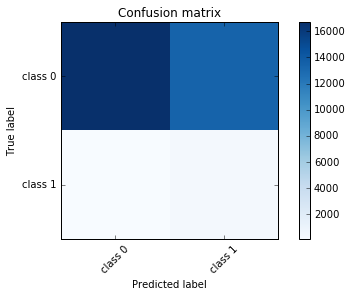

In [20]:
predicted_probs_3 = logreg3.predict_proba(X_test)
print "Average accuracy %.4f'" % logreg3.score(X_test, y_test)
print
print "Predictions:\n", pd.value_counts(promo_pred_3)

print "Confusion Matrix:\n"
print(get_confusion_matrix(y_test, promo_pred_3))
# Compute confusion matrix
cm_3 = confusion_matrix(y_test, promo_pred_3)

pyplot.figure()
plot_confusion_matrix(cm_3)

In [22]:
print "Classification report\n", classification_report(y_test, promo_pred_3)
print
# Look at which coefficients mig
zip(X_test.columns, logreg3.coef_.flatten())

Classification report
             precision    recall  f1-score   support

          0       0.99      0.55      0.71     30233
          1       0.03      0.83      0.06       488

avg / total       0.98      0.56      0.70     30721




[(u'impressions_fan_unique', 0.100052594987574),
 (u'consumptions_unique', 0.62319698181722138),
 (u'negative_feedback_unique', 0.064015839770575581),
 (u'video_views_organic_unique', 1.11095550056947),
 (u'impressions_organic_unique', -0.83775778321777095)]

### Logistic Regression 3 Results:
* Predictions are a bit more balanced
* Precision is low for promoted posts as it incorrectly classifies alot of posts as promoted (false positives)
* Recall/Sensitivity is low for unpromoted posts - number of prediction unpromoted posts is low in comparison to the total number of unpromoted posts
* Coefficients seems to indicate some relationship to output, need to work on selecting better features

### Next steps
* Take a look at feature importance using decision tree classifier
* Run Logistic Regression on a best features


In [158]:
'''
FEATURE IMPORTANCE USING DECISION TREE
'''
X, y = shuffle(data.ix[:, 1:-3], data.is_promoted, random_state=23)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.15, random_state=1)

tree_model = tree.DecisionTreeClassifier(criterion='gini')
tree_model = tree.DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

tree_predicted = tree_model.predict(X_test)

In [159]:
tree_impt = tree_model.feature_importances_
# get sorted index 
sorted_idx_tree = np.argsort(tree_impt)
for f in xrange(len(X.columns),0,-1):
    print("%d. feature %d (%f)  %s" % (f , sorted_idx[f-1], tree_impt[sorted_idx_tree[f-1]], X.columns[sorted_idx_tree[f-1]]))



12. feature 0 (0.398624)  impressions_fan_unique
11. feature 10 (0.140910)  impressions_organic_unique
10. feature 1 (0.096830)  impressions_by_story_type_unique_other
9. feature 2 (0.062721)  consumptions_unique
8. feature 6 (0.060194)  consumptions_by_type_unique_other_clicks
7. feature 11 (0.059505)  video_views_organic_unique
6. feature 7 (0.047170)  consumptions_by_type_unique_link_clicks
5. feature 9 (0.029568)  consumptions_by_type_unique_photo_view
4. feature 4 (0.027654)  negative_feedback_unique
3. feature 5 (0.026745)  video_complete_views_organic_unique
2. feature 8 (0.026578)  negative_feedback_by_type_unique_hide_clicks
1. feature 3 (0.023500)  negative_feedback_by_type_unique_hide_all_clicks


Average accuracy 0.9920'

Predictions:
0    30221
1      500
dtype: int64
Confusion Matrix:

          0-Predicted  1-Predicted
0-Actual        30083          109
1-Actual          138          391


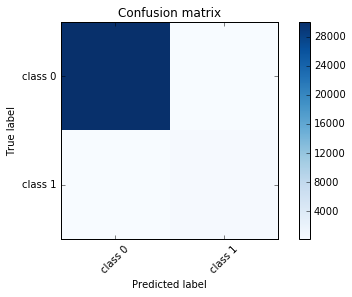

In [160]:
print "Average accuracy %.4f'" % tree_model.score(X_test, y_test)
print
print "Predictions:\n", pd.value_counts(tree_predicted)

print "Confusion Matrix:\n"
print(get_confusion_matrix(y_test, tree_predicted))
# Compute confusion matrix
cm_tree = confusion_matrix(y_true=y_test, y_pred=tree_predicted)

pyplot.figure()
plot_confusion_matrix(cm_tree)

In [161]:
print(classification_report(y_test, tree_predicted, target_names= target_names))
n_classes=2
tree_predicted_proba = tree_model.predict_proba(X_test)

             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00     30192
    class 1       0.78      0.74      0.76       529

avg / total       0.99      0.99      0.99     30721



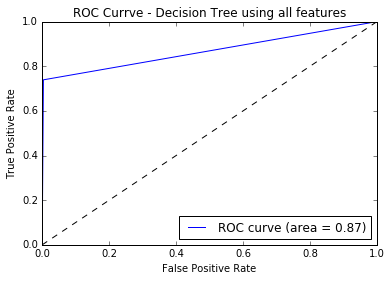

In [162]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _  = roc_curve(y_test, tree_predicted_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
pyplot.figure()    
pyplot.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1])
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Currve - Decision Tree using all features')
pyplot.legend(loc="lower right")
pyplot.show()

### Decision Tree Results
* after fitting the model on all the features, it performs alot better than logistic regression
* scores perfectly on unpromoted posts and very well on promoted posts

#### Let's see how logistic regression performs when subsetting 5 most important features

In [168]:
X, y = shuffle(data.ix[:, 1:-3], data.is_promoted, random_state=23)
best_cols = [X.columns[sorted_idx_tree[i-1]] for i in xrange(12,6,-1)]
    
'''
Logistic Regression #4 - on .90 dataset & top 5 impt features
'''

X = data[best_cols]
y = data.is_promoted
# training and testing
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.1, random_state=1)
Cs = np.logspace(-4, 4, 3)

logreg4 = LogisticRegression(C=Cs[1], class_weight='balanced', multi_class = 'ovr')
logreg4.fit(X_train,y_train)
promo_pred_4 = logreg4.predict(X_test)

Average accuracy 0.7931'

Predictions:
0    16185
1     4296
dtype: int64
Confusion Matrix:

          0-Predicted  1-Predicted
0-Actual        16046         4099
1-Actual          139          197


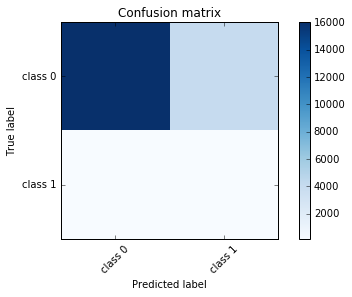

In [169]:
print "Average accuracy %.4f'" % logreg4.score(X_test, y_test)
print
print "Predictions:\n", pd.value_counts(promo_pred_4)

print "Confusion Matrix:\n"
print(get_confusion_matrix(y_test, promo_pred_4))
# Compute confusion matrix
cm_4 = confusion_matrix(y_true=y_test, y_pred=promo_pred_4)

pyplot.figure()
plot_confusion_matrix(cm_4)

In [170]:
print "Decision Tree picks out best features as:\n", best_cols
print
print(classification_report(y_test, promo_pred_4, target_names= target_names))
# Look at coefficients 
zip(X_test.columns, logreg4.coef_.flatten())

Decision Tree picks out best features as:
[u'impressions_fan_unique', u'impressions_organic_unique', u'impressions_by_story_type_unique_other', u'consumptions_unique', u'consumptions_by_type_unique_other_clicks', u'video_views_organic_unique']

             precision    recall  f1-score   support

    class 0       0.99      0.80      0.88     20145
    class 1       0.05      0.59      0.09       336

avg / total       0.98      0.79      0.87     20481



[(u'impressions_fan_unique', -0.14364394582778564),
 (u'impressions_organic_unique', -1.424936626275723),
 (u'impressions_by_story_type_unique_other', -2.3342143746821065),
 (u'consumptions_unique', 7.735608751945624),
 (u'consumptions_by_type_unique_other_clicks', -10.353440292251369),
 (u'video_views_organic_unique', 7.0110744878655691)]

In [171]:
promo_pred_prob_4 = logreg4.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, promo_pred_prob_4[:,1])
n_classes =2

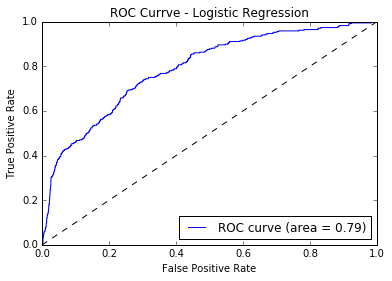

In [172]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _  = roc_curve(y_test, promo_pred_prob_4[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
pyplot.figure()    
pyplot.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1])
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Currve - Logistic Regression')
pyplot.legend(loc="lower right")
pyplot.show()

### Logistic Regression 4 Results:
* Decision Tree on all features performs better than any of the logistic regression models
* However, average accuracy for logistic regression on a subset of features is better than in 3rd attempt because the model is only taking into account the features that are the most important in explaining the output
* Recall/Sensitivity (true positive rate) is higher (.59), meaning it correctly classified promoted posts better
* Precision is low for promoted posts as model incorrectly classifies alot of posts as promoted compared to actual number of promoted posts (false positives)
* Coefficients seems to indicate some relationship to output, need to work on selecting better features

### Next steps
* Discuss Boosting methods/Ada Boost
* Fit Decision Tree/Random Forest on subset of columns
* Look at ADA Boost

In [175]:
X, y = shuffle(data.ix[:, 1:-3], data.is_promoted, random_state=10)
X = data[best_cols]
y = data.is_promoted
# training and testing
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.1, random_state=1)

tree_model_small = tree.DecisionTreeClassifier(criterion='gini')
tree_model_small.fit(X_train, y_train)
tree_predicted_small = tree_model_small.predict(X_test)

Average accuracy 0.9923'

Predictions:
0    20143
1      338
dtype: int64
Confusion Matrix:

          0-Predicted  1-Predicted
0-Actual        20065           80
1-Actual           78          258


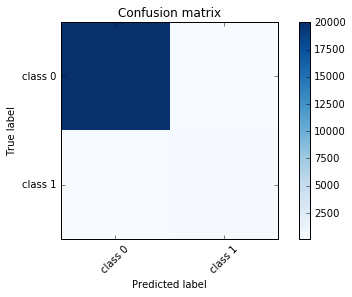

In [176]:
print "Average accuracy %.4f'" % tree_model_small.score(X_test, y_test)
print
print "Predictions:\n", pd.value_counts(tree_predicted_small)

print "Confusion Matrix:\n"
print(get_confusion_matrix(y_test, tree_predicted_small))
# Compute confusion matrix
cm_tree_small = confusion_matrix(y_true=y_test, y_pred=tree_predicted_small)

pyplot.figure()
plot_confusion_matrix(cm_tree_small)

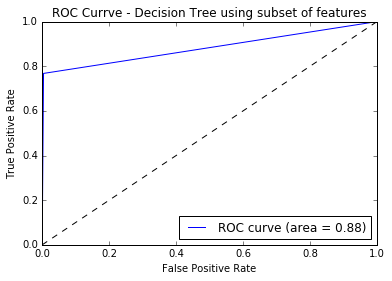

In [178]:
tree_small_predicted_proba = tree_model_small.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _  = roc_curve(y_test, tree_small_predicted_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
pyplot.figure()    
pyplot.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1])
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Currve - Decision Tree using subset of features')
pyplot.legend(loc="lower right")
pyplot.show()

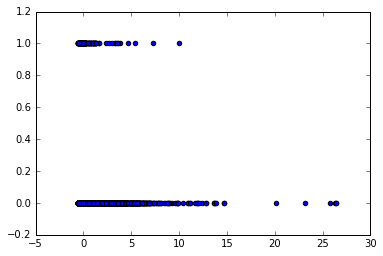

In [179]:
pyplot.scatter(x = X_test.impressions_fan_unique, y = y_test)
pyplot.plot(x = X_test.impressions_fan_unique, y = tree_predicted_small)
pyplot.show()

In [180]:
'''
RANDOM FOREST
'''
rf = RandomForestClassifier(n_estimators = 500)
rf.fit(X_train, y_train)
rf_predicted = rf.predict(X_test)

In [181]:
print rf.score(X_test, y_test)
print (classification_report(y_test, rf_predicted, target_names= target_names))

0.994336214052
             precision    recall  f1-score   support

    class 0       0.99      1.00      1.00     20145
    class 1       0.99      0.66      0.79       336

avg / total       0.99      0.99      0.99     20481



Average accuracy 0.9923'

Predictions:
0    20143
1      338
dtype: int64
Confusion Matrix:

          0-Predicted  1-Predicted
0-Actual        20065           80
1-Actual           78          258


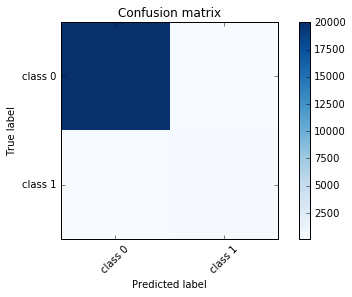

In [182]:
print "Average accuracy %.4f'" % tree_model_small.score(X_test, y_test)
print
print "Predictions:\n", pd.value_counts(tree_predicted_small)

print "Confusion Matrix:\n"
print(get_confusion_matrix(y_test, tree_predicted_small))
# Compute confusion matrix
cm_tree_small = confusion_matrix(y_true=y_test, y_pred=tree_predicted_small)

pyplot.figure()
plot_confusion_matrix(cm_tree_small)

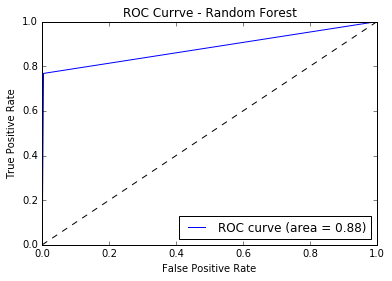

In [183]:
rf_predicted_proba = tree_model_small.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _  = roc_curve(y_test, rf_predicted_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
pyplot.figure()    
pyplot.plot(fpr[1], tpr[1], label='ROC curve (area = %0.2f)' % roc_auc[1])
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Currve - Random Forest')
pyplot.legend(loc="lower right")
pyplot.show()

In [23]:
'''
FEATURE IMPORTANCE USING GRADIENT BOOSTING CLASSIFIER
'''
X, y = shuffle(data.ix[:, 1:-3], data.is_promoted, random_state=23)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.15, random_state=1)

n_estimators = 150
# Use Gradient Boosting Regression method to find relative feature importance
params = {'n_estimators': n_estimators, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.01, 'loss': 'ls'}
#ens_reg = ensemble.GradientBoostingClassifier(**params)


grd = ensemble.GradientBoostingClassifier(n_estimators=n_estimators)
grd.fit(X_train,y_train)
grd_predicted = grd.predict(X_test)

feature_importance = grd.feature_importances_
# get sorted index 
sorted_idx = np.argsort(feature_importance)
for f in xrange(len(X.columns),0,-1):
    print("%d. feature %d (%f)  %s" % (f , sorted_idx[f-1], feature_importance[sorted_idx[f-1]], X.columns[sorted_idx[f-1]]))



12. feature 0 (0.041753)  video_complete_views_organic_unique
11. feature 1 (0.064393)  video_views_organic_unique
10. feature 2 (0.023853)  negative_feedback_unique
9. feature 6 (0.058216)  negative_feedback_by_type_unique_hide_all_clicks
8. feature 10 (0.015871)  negative_feedback_by_type_unique_hide_clicks
7. feature 3 (0.082734)  consumptions_unique
6. feature 8 (0.042476)  consumptions_by_type_unique_other_clicks
5. feature 5 (0.040601)  consumptions_by_type_unique_photo_view
4. feature 11 (0.061313)  consumptions_by_type_unique_link_clicks
3. feature 4 (0.107170)  impressions_by_story_type_unique_other
2. feature 9 (0.150459)  impressions_organic_unique
1. feature 7 (0.311161)  impressions_fan_unique


## TO DO:
    BOOSTING Discussion

In [39]:
# Use Gradient Boosting Regression 

X, y = shuffle(data.ix[:, 1:-3], data.is_promoted, random_state=23)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=1)

n_estimators = 100

# params = {'n_estimators': n_estimators, 'max_depth': 4, 'min_samples_split': 1,
#           'learning_rate': 0.01, 'loss': 'ls'}

params = {'n_estimators': n_estimators, 'max_depth': 4, 'min_samples_split': 1,
          'learning_rate': 0.01}

grd = ensemble.GradientBoostingClassifier(**params)
grd.fit(X_train,y_train)
grd_predicted = grd.predict(X_test)

In [42]:
# get feature importance
feature_importance = grd.feature_importances_

# get sorted index for feature importance 
sorted_idx = np.argsort(feature_importance)
for f in xrange(len(X.columns),0,-1):
    print("%d. feature %d (%f)  %s" % (f , sorted_idx[f-1], feature_importance[sorted_idx[f-1]], X.columns[sorted_idx[f-1]]))



12. feature 0 (0.644725)  impressions_fan_unique
11. feature 10 (0.110649)  video_views_organic_unique
10. feature 1 (0.097465)  impressions_organic_unique
9. feature 2 (0.039916)  impressions_by_story_type_unique_other
8. feature 6 (0.026319)  consumptions_unique
7. feature 11 (0.025785)  video_complete_views_organic_unique
6. feature 7 (0.018461)  negative_feedback_by_type_unique_hide_clicks
5. feature 9 (0.018084)  negative_feedback_unique
4. feature 4 (0.005740)  consumptions_by_type_unique_photo_view
3. feature 5 (0.004961)  consumptions_by_type_unique_other_clicks
2. feature 8 (0.004733)  negative_feedback_by_type_unique_hide_all_clicks
1. feature 3 (0.003161)  consumptions_by_type_unique_link_clicks


Average accuracy 0.9862'
Predictions:
0    40845
1      116
dtype: int64

Confusion Matrix:

          0-Predicted  1-Predicted
0-Actual        40280            1
1-Actual          565          115


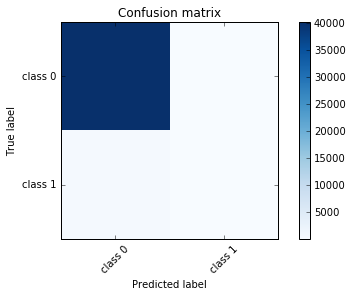

In [43]:
print "Average accuracy %.4f'" % grd.score(X_test, y_test)
print "Predictions:\n", pd.value_counts(grd_predicted)
print
print "Confusion Matrix:\n"
print(get_confusion_matrix(y_test, grd_predicted))
# Compute confusion matrix
cm_5 = confusion_matrix(y_test, grd_predicted)

pyplot.figure()
plot_confusion_matrix(cm_5)

In [44]:
print(classification_report(y_test, grd_predicted, target_names= target_names))


             precision    recall  f1-score   support

    class 0       0.99      1.00      0.99     40281
    class 1       0.99      0.17      0.29       680

avg / total       0.99      0.99      0.98     40961



In [33]:
original_params = {'n_estimators': 1000, 'max_leaf_nodes': 4, 'max_depth': None, 'random_state': 2,
                   'min_samples_split': 5}

params = {'n_estimators': n_estimators, 'max_depth': None, 'min_samples_split': 5,
          'learning_rate': 0.01, 'loss': 'ls'}
# compute test set deviance
test_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, grd_predicted in enumerate(grd.staged_decision_function(X_test)):
    # clf.loss_ assumes that y_test[i] in {0, 1}
    test_deviance[i] = grd.loss_(y_test, grd_predicted)

Average accuracy 0.9929'
Predictions:
0    40294
1      667
dtype: int64

Confusion Matrix:

          0-Predicted  1-Predicted
0-Actual        40143          138
1-Actual          151          529


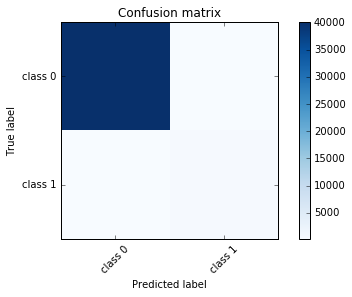

In [70]:
print "Average accuracy %.4f'" % model.score(X_test, y_test)
print "Predictions:\n", pd.value_counts(tree_predicted)
print
print "Confusion Matrix:\n"
print(get_confusion_matrix(y_test, tree_predicted))
# Compute confusion matrix
cm_6 = confusion_matrix(y_test, tree_predicted)

pyplot.figure()
plot_confusion_matrix(cm_6)

In [74]:
model_impt = model.feature_importances_
sorted_idx_tree = np.argsort(model_impt)

for f in xrange(len(X.columns),0,-1):
    print("%d. feature %d (%f)  %s" % (f , sorted_idx_tree[f-1], model_impt[sorted_idx_tree[f-1]], X.columns[sorted_idx_tree[f-1]]))



12. feature 0 (0.389361)  impressions_fan_unique
11. feature 1 (0.144771)  impressions_organic_unique
10. feature 2 (0.109002)  impressions_by_story_type_unique_other
9. feature 5 (0.064081)  consumptions_by_type_unique_other_clicks
8. feature 6 (0.063806)  consumptions_unique
7. feature 11 (0.051506)  video_complete_views_organic_unique
6. feature 10 (0.033919)  video_views_organic_unique
5. feature 3 (0.033266)  consumptions_by_type_unique_link_clicks
4. feature 4 (0.031970)  consumptions_by_type_unique_photo_view
3. feature 7 (0.030759)  negative_feedback_by_type_unique_hide_clicks
2. feature 9 (0.028438)  negative_feedback_unique
1. feature 8 (0.019122)  negative_feedback_by_type_unique_hide_all_clicks


In [77]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 500)
rf.fit(X_train, y_train)
rf_predicted = rf.predict(X_test)

In [78]:
print rf.score(X_test, y_test)
print (classification_report(y_test, rf_predicted, target_names= target_names))

0.994921998975
             precision    recall  f1-score   support

    class 0       0.99      1.00      1.00     40281
    class 1       1.00      0.69      0.82       680

avg / total       0.99      0.99      0.99     40961

